<a href="https://colab.research.google.com/github/srigit-dot/machine-learning/blob/main/CAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.1531 - loss: 2.3207

🔢 Enter an index from test set (0-9999): 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


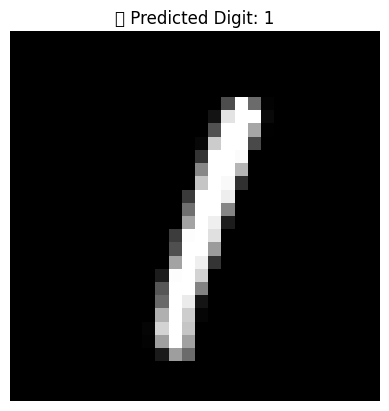

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# --- Capsule Layers and Squash ---

def squash_fn(vectors, axis=-1):
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm)
    return scale * vectors / tf.sqrt(s_squared_norm + 1e-9)

class Squash(layers.Layer):
    def call(self, inputs, **kwargs):
        return squash_fn(inputs)

class Length(layers.Layer):
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1) + 1e-9)

class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        self.input_num_capsules = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        self.W = self.add_weight(
            shape=[self.input_num_capsules, self.num_capsules, self.input_dim_capsule, self.dim_capsule],
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs):
        # inputs shape: [batch_size, input_num_capsules, input_dim_capsule]
        inputs_expand = tf.expand_dims(inputs, 2)  # [batch, input_caps, 1, dim_caps]
        inputs_tiled = tf.expand_dims(inputs_expand, 3)  # [batch, input_caps, 1, 1, dim_caps]

        # W shape: [input_caps, output_caps, input_dim, output_dim]
        W_tiled = tf.expand_dims(self.W, 0)  # [1, input_caps, output_caps, input_dim, output_dim]
        u_hat = tf.matmul(inputs_tiled, W_tiled)  # [batch, input_caps, output_caps, 1, output_dim]
        u_hat = tf.squeeze(u_hat, axis=3)  # [batch, input_caps, output_caps, output_dim]

        b = tf.zeros_like(u_hat[..., 0])  # [batch, input_caps, output_caps]

        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)  # softmax over output_caps
            outputs = squash_fn(tf.reduce_sum(c[..., None] * u_hat, axis=1))  # [batch, output_caps, output_dim]
            if i < self.routings - 1:
                b += tf.reduce_sum(u_hat * outputs[:, None, :, :], axis=-1)

        return outputs

# --- Build Capsule Model ---
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(256, 9, activation='relu')(inputs)
x = layers.Conv2D(32 * 8, 9, strides=2, activation='relu')(x)
x = layers.Reshape((-1, 8))(x)  # 1152 primary capsules, each with 8D
x = Squash()(x)

caps = CapsuleLayer(num_capsules=10, dim_capsule=16)(x)
outputs = Length()(caps)

model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train Model (small subset for quick test) ---
model.fit(x_train[:1024], y_train[:1024], batch_size=64, epochs=1)

# --- User Input for Prediction ---
index = int(input("\n🔢 Enter an index from test set (0-9999): "))
while not (0 <= index < len(x_test)):
    index = int(input("Please enter a valid index: "))

sample = np.expand_dims(x_test[index], axis=0)
prediction = model.predict(sample)
predicted_digit = np.argmax(prediction)

# --- Display Prediction ---
plt.imshow(x_test[index].reshape(28,28), cmap='gray')
plt.title(f"🧠 Predicted Digit: {predicted_digit}")
plt.axis('off')
plt.show()